Date: Nov 2025
    
Author:Aminath Shausan
    
This program provide code to predicts influenza rate from  Google Trends data using elastic net, support vector, random forest, and feedforward neural network regression models. Each model is fitted seperately to each region data. 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
path = '/<PUT YOUR PATH>/Digital-Disease-Surveillance'

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error   #to compute RMSE

from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.linear_model import Ridge # for Ridge regression
from sklearn.linear_model import Lasso # for LASSO regression 
from sklearn.linear_model import LassoCV # for LASSO regression 
from sklearn.linear_model import ElasticNet # for ElasticNet regression 
from sklearn.linear_model import ElasticNetCV # for ElasticNet regression 
from sklearn.svm import SVR #for support vector regression

from sklearn.pipeline import Pipeline #for using pipeline 
from sklearn.preprocessing import StandardScaler #for scaling data to mean 0, unit variance
from sklearn.model_selection import GridSearchCV #for Grid Search cross validation
from sklearn.model_selection import RandomizedSearchCV #for random grid search
from sklearn.metrics import mean_squared_error   #to compute RMSE
from sklearn.metrics import mean_absolute_error   #to compute RMSE

from sklearn.preprocessing import MinMaxScaler #for scaling data to range [0,1]
from sklearn.neural_network import MLPRegressor  #for feedforward neural network

from sklearn.ensemble import RandomForestRegressor #for Random Forest regression
from sklearn.model_selection import TimeSeriesSplit 

In [86]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "sans-serif"

# Modelling


For each type of model, consider the following: 
- ***zero week*** ahead estimates (nowcast):- use GT data at week (t) to predict flu incidence at the end of current week (t)
- ***one week*** ahead estimates:- use GT data at week (t) to predict flu incidence  of next week (t+1)
- ***two week*** ahead estimates:- use GT data at week (t) to predict flu incidence at the end of next 2 weeks (t+2)
- sequentially partition data into training (80%) and test sets (20%) 
- 80% of data is maintained for training fpr different week ahead estimates, while the test set reduced by 1 and 2 instances for one-week and two-weeks ahead respectively 
- perform 5-fold temporal cross-validation to find optimal hyper-parameter 

Note: 
- total number of weeks for each state excluding Covid period 104 (80% = 83rows, 20% = 21 remaining rows )
- for FFNN model, need to transform data into a range [0,1] using min-max scaling prior to giving it as input

Measureing Performances: using test set only
- Root means squared error (RMSE)
- mean absolute error (MAE)
- Pearson correlation coefficient (PCC) of the estimated and the true incidence rates

Predict Peak week and Height of Peak:
- peak week difference (PWD):= difference bwtween the true and estimated peak week
- peak magnitude difference (PMD) := difference between the true and the forecasted peak height
- the lower the PWD and PMD, the better the model performance.

In [ ]:

#define a function to read data, prepare y and X data
def read_data(state, drops):
    ###################
    #state = name of state
    #drops = list of columns to drop
    #########################
    df = pd.read_csv(path + '/data/'+ state + '_gt_flu_.csv')
    print('df shape:', df.shape)
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d') #convert to date object
    df= df[df['date']< '2020-01-01'] #exclude covid period 
    dates = df['date']
    # get X and y data 
    y = df['totalCount'] #series
    X = df.drop(drops, axis = 1) #dataframe
    y_scaled = (y - y.min()) / (y.max() - y.min())*100 #scale y to be between [0 100]
    print("y shape:", y.shape) #
    print("y_scaled range:", [y_scaled.min(), y_scaled.max()]) #
    print("X shape:", X.shape) #
    features = X.columns
    
    
    return y_scaled, X, features, dates
###########################################################################################

#define a function to get nowcast data
def nowcast_data(y_scaled, X, split):
    #################
    #split = row number to split X and y so that test/train ratio is 80% and 20%
    ####################
    y_train = y_scaled[:split]
    y_test = y_scaled[split:]
    print("Nowcast y train and test shape:", y_train.shape, y_test.shape) # 
    X_train = X.head(split)
    X_test = X.tail(X.shape[0]-split)
    print("Nowcast X train and test shape:", X_train.shape, X_test.shape)  
    return y_train, y_test, X_train, X_test
######################################################################################

#define a function to get data for 1 wk ahead forecast
def one_week_data(y_scaled, X, split):
    ####################
    X_train = X.head(split) #(
    X_test = X.tail(X.shape[0]-split).head(-1) #
    print("One week X train and test shape:", X_train.shape, X_test.shape)
    y_train = y_scaled[:split+1].drop(0) #
    y_test = y_scaled[split+1:] #(20,)
    print("One week y train and test shape:", y_train.shape, y_test.shape)  
    
    return y_train, y_test, X_train, X_test
######################################################################################

#define a function to get data for 2 wks ahead forecast
def two_week_data(y_scaled, X, split):
    ####################
    X_train = X.head(split) #
    X_test = X.tail(X.shape[0]-split).head(-2) #
    print("Two weeks X train and test shape:", X_train.shape, X_test.shape)
    y_train = y_scaled[:split+2].drop([0,1]) #
    y_test = y_scaled[split+2:] #(20,)
    print("Two weeks y train and test shape:", y_train.shape, y_test.shape)  
    
    return y_train, y_test, X_train, X_test
######################################################################################


##### evaluate model performances
def evaluate(model, X_test, y_test):

    y_pred = model.predict(X_test)
    #create dataframe of actual and predicted values
    df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    pcc = df_y_pred.corr()[['Actual']].round(4).iloc[1,0] #Pearson Correlation coeff 
    r2 = model.score(X_test, y_test).round(4)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    mae = mean_absolute_error(y_test, y_pred).round(4)
    #compute MAPE and accuracy
    errors = abs(y_pred - y_test)
    mape = 100 * (errors/y_test)
    accuracy = 100 - np.mean(mape)
    
    print("R squared: {}".format(r2))
    print("RMSE: {}".format(rmse))
    print("MAE: {}".format(mae))
    print("PCC: {}".format(pcc))
    print('Accuracy:', round(accuracy, 2), '%.')

    return y_pred, pcc, r2, rmse, mae, accuracy
#################################################################
## use timeseries split for 5-fold cross-validation

# TimeSeriesSplit
tscv = TimeSeriesSplit(
    n_splits=5,          # expand/roll forward 5 times
    test_size=8          # size of each validation fold (in weeks)
    # max_train_size = 42
)
tscv 

############################################

#ElasticNetCV

def enet_reg(X_train, y_train, X_test, y_test):
    
    param_grid = [.1, .5, .7, .9, .95, .99, 1] #
    
    # Setup the ElasticNetCV object: 
    enet_cv =  ElasticNetCV(cv=5, l1_ratio = param_grid, positive = False,
                   random_state = 0)  
 
    # Fit it to the training data
    enet_cv.fit(X_train, y_train)
    # R2 on training set
    r2_train = enet_cv.score(X_train, y_train).round(4) #

    # Predict on the test set and compute metrics
    y_pred = enet_cv.predict(X_test)
    df_y_pred = pd.DataFrame(y_test)
    df_y_pred['y_pred'] = y_pred.tolist()
    
    pcc = df_y_pred.corr()[['totalCount']].round(4).iloc[1,0] #Pearson Correlation coeff 
    r2 = enet_cv.score(X_test, y_test).round(4) #R-squared of test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4) #RMSE of test set
    mae = mean_absolute_error(y_test, y_pred).round(4) #MAE of test set
    print("Tuned  l1 ratio: {}".format(enet_cv.l1_ratio_))
    print("Tuned  alpha: {}".format(enet_cv.alpha_.round(1)))
    print("Tuned score: {}".format(r2_train)) #this is mean R2 value of trainign set  
    print("R squared: {}".format(r2))
    print("RMSE: {}".format(rmse))
    print("MAE: {}".format(mae))
    print("PCC: {}".format(pcc))
    
   
 #### #refit model with best parameters and get important features #####
## Extract the l1_ratio, alpha, max_iter from cv model
    alpha = enet_cv.alpha_.round(1)
    l1ratio = enet_cv.l1_ratio_
    maxiter = enet_cv.n_iter_
    print("alpha: {}".format(alpha))
    print('l1 ratio: {}'.format(l1ratio)) 
    print("max iter: {}".format(maxiter))
    
    enet_refit = ElasticNet(alpha = alpha, l1_ratio=l1ratio,  max_iter=maxiter, 
                            fit_intercept=True, random_state=0)
    enet_refit.fit(X_train, y_train)
    
     #number of features and their names seen during fit 
    feature_importance = pd.Series(index = X_train.columns, data = np.abs(enet_refit.coef_)).sort_values(ascending=False)
    # print(feature_importance.values)
    n_selected_features = (feature_importance>0).sum()
    print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,(1-n_selected_features/len(feature_importance))*100))
    # Make a line graph
   
    plt.plot(feature_importance.index, feature_importance.values, color = 'g',)
    plt.hlines(y = 0.1, xmin=0, xmax=len(feature_importance.index), color = 'r', linestyles = 'dashed')
    plt.xticks(feature_importance.index, feature_importance.index, rotation = 'vertical')
    # plt.grid(linestyle=':')
    # plt.xlabel(' '); 
    plt.ylabel('Absolule value of coefficients'); 
    return enet_cv, y_pred
 
################################################################################

#Support Vector Regression with GridsearchCV
def svr_reg(X_train, y_train, X_test, y_test):

    steps = [('scaler', MinMaxScaler()), 
             ('svr', SVR())]
    pipeline = Pipeline(steps)    #create a pipeline
    param_grid = {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], #k
                  'svr__degree': [1, 2, 3], #default =3
              'svr__C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 
             'svr__epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1.1]} #s
    svr_cv = GridSearchCV(pipeline, param_grid, cv =5) #u
    svr_cv.fit(X_train, y_train) #

    # # Predict on the test set and compute metrics
    y_pred = svr_cv.predict(X_test)
    df_y_pred = pd.DataFrame(y_test)
    df_y_pred['y_pred'] = y_pred.tolist()
    pcc = df_y_pred.corr()[['totalCount']].round(4).iloc[1,0] #Pearson Correlation coeff 
    r2 = svr_cv.score(X_test, y_test).round(4)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    mae = mean_absolute_error(y_test, y_pred).round(4)
    print("Tuned  parameters: {}".format(svr_cv.best_params_))
    print("Tuned  R squared: {}".format(svr_cv.best_score_.round(4)))
    print("R squared: {}".format(r2))
    print("RMSE: {}".format(rmse))
    print("MAE: {}".format(mae))
    print("PCC: {}".format(pcc))

    return svr_cv, y_pred


  
################################################################################

### Feeforward Neural Network  Gridsearch CV

def fnn_reg(X_train, y_train, X_test, y_test):
    
    param_grid = {
        'mlpreg__alpha': [0.0001, 0.001,  0.005, 0.01, 0.1, 1.0, 1.1], 
        'mlpreg__learning_rate': ['constant','adaptive']#
        }

    steps = [('scaler', MinMaxScaler()),  #MinMaxScaler()
          ('mlpreg', MLPRegressor(hidden_layer_sizes=(X_train.shape[1], 50, 25), activation='relu', 
                                  solver = 'adam', max_iter = 1000, early_stopping=True,
                                  random_state=1
                                 ))]

  
    pipeline = Pipeline(steps)    #
    mlpreg_cv = GridSearchCV(pipeline, param_grid, cv=5) #
    mlpreg_cv.fit(X_train, y_train)

    y_pred = mlpreg_cv.predict(X_test)
    df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    pcc = df_y_pred.corr()[['Actual']].round(4).iloc[1,0] #Pearson Correlation coeff 
    r2 = mlpreg_cv.score(X_test, y_test).round(4)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    mae = mean_absolute_error(y_test, y_pred).round(4)
 
    print("Tuned  estimator: {}".format(mlpreg_cv.best_estimator_)) 
    print("Tuned  parameters: {}".format(mlpreg_cv.best_params_)) 
    print("Tuned  R squared: {}".format(mlpreg_cv.best_score_.round(4)))
    print("R squared: {}".format(r2))
    print("RMSE: {}".format(rmse))
    print("MAE: {}".format(mae))
    print("PCC: {}".format(pcc))
    
    return mlpreg_cv, y_pred

################################################################
### Random Forest  Gridsearch CV

def rf_reg(X_train, y_train, X_test, y_test):
#create a baseline model
    rf_est = RandomForestRegressor(random_state=0)

#define hyperparameters
    param_grid = {
               'n_estimators': [50, 100, 150],
               #'max_features': ['sqrt', 'log2'],
               'max_depth': [2, 8, 10, 16, 20, None]
               #'min_samples_split': [1, 2, 5, 10],
               #'min_samples_leaf': [1, 2, 4, 5],
               #'bootstrap': [True, False]
    }

# # Instantiate the grid search model
    rf_cv = GridSearchCV(rf_est, param_grid, cv = 5) #
    rf_cv.fit(X_train, y_train)

    y_pred = rf_cv.predict(X_test)
    df_y_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    pcc = df_y_pred.corr()[['Actual']].round(4).iloc[1,0] #Pearson Correlation coeff 
    r2 = rf_cv.score(X_test, y_test).round(4)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    mae = mean_absolute_error(y_test, y_pred).round(4)
 
    print("Tuned  estimator: {}".format(rf_cv.best_estimator_)) 
    print("Tuned  parameters: {}".format(rf_cv.best_params_)) 
    print("Tuned  R squared: {}".format(rf_cv.best_score_.round(4)))
    print("R squared: {}".format(r2))
    print("RMSE: {}".format(rmse))
    print("MAE: {}".format(mae))
    print("PCC: {}".format(pcc))
    
#     ##### #refit model with best parameters and get important features #####
    n_est = rf_cv.best_params_['n_estimators']
    max_dpt = rf_cv.best_params_['max_depth']
    print([n_est, max_dpt])

    rf_regr_refit = RandomForestRegressor(n_estimators = n_est, max_depth = max_dpt, random_state=0) #refit model with best params
    rf_regr_refit.fit(X_train, y_train);
    # Get numerical feature importances
    importances = list(rf_regr_refit.feature_importances_)
    print('numerical important features:',importances)
    
    # List of tuples with variable and importance
    feature_list = list(X_train.columns)
    feature_importances = [(feature, round(importance, 2)) for feature, 
                       importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    sorted_importances = [importance[1] for importance in feature_importances] #list of scores for important features 
    sorted_features = [importance[0] for importance in feature_importances] #list of important feature names 
    cumulative_importances = np.cumsum(sorted_importances)
    # Make a line graph
    x_values = list(range(len(importances))) 
    plt.plot(x_values, cumulative_importances, 'g-')
    plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
    plt.xticks(x_values, sorted_features, rotation = 'vertical')
    # plt.grid(linestyle=':')
    plt.xlabel(' '); plt.ylabel('Cumulative Importance'); 
    # plt.title('Cumulative Importances');

# Find number of features for cumulative importance of 95%
    num_importand_features = np.where(cumulative_importances >= 0.95)[0][0] + 1
    important_feature_names = [feature[0] for feature in feature_importances[0:num_importand_features-1]]
    print('Important features:', important_feature_names)
    # print(sorted_importances)
    # print(sorted_features)
    return rf_cv, y_pred
####################################################

############################################################################
 
def plot_pred(dates, y_scaled, y_pred_new, split): 

    dates_pred = dates[split:] #(21,)   #    

    #plot figure
    p = plt.figure(figsize=(8, 6))
    plt.plot(dates, y_scaled, 'b', label = 'Actual')
    plt.plot(dates_pred, y_pred_new, 'r', label = 'Predicted') #use this for others
    plt.legend(frameon=False)
    # plt.grid(linestyle=':')
    plt.ylabel("Weekly influenza rate (%)", fontsize=12, fontname="sans-serif") 
    # plt.xlabel("Date", fontsize=12) 
    plt.xticks(rotation= 60, fontsize=12, fontname="sans-serif") #'vertical'
    plt.margins(0.02)
    return p
    
    
######################################################################################
#get differences between peak height (PMD) and peak week (PWD): values of these closer to 0 are better 
# PMD = max(y_test) – max(y_pred);   If PMD is negative => peak height is over predicted
# PWD = time of max(y_test) – time of max(y_pred);  If PWD is negative => peak time is over 

def severity(dates, y_test_new, y_pred_new, split): 
    dates_pred = dates[split:] #(21,)   #dates for prediction
    df_y_pred = pd.DataFrame({'date':dates_pred,'y_pred':y_pred_new}) #
    df_y_pred['y_test'] = y_test_new.tolist()    

    PMD = round(max(df_y_pred['y_test']), 4)- round(max(df_y_pred['y_pred']), 4)
    idx_max = df_y_pred.idxmax(axis = 0).values
    print('index of max y_test: ', idx_max[1]) 
    print('index of max y_pred: ', idx_max[2]) 
    PWD = idx_max[2] -idx_max[1] #peak weak differnce
    # print('PWD: ',   PWD)
    lst_severity = {'PMD': round(PMD,4), 'PWD': PWD}
    print(lst_severity)
    # df_y_pred
    return df_y_pred #lst_severity

In [ ]:
### -------- do this for each state seperately

# state = 'nsw'
# drops = ['date', 'Year_x', 'State', 'H9N2', 'totalCount'] #ignore  keywords with no data
##########################################
# state = 'nt'
# # Exclude all cols apart from these: influenza, H1N1, rhinovirus, pneumonia, bronchitis, Tamiflu 
# drops = ['date', 'Year_x', 'State',  'Haemophilus influenzae', 'parainfluenza',
#          'H7N9', 'H5N1', 'H3N2', 'grippe', 'gripe', 'adenovirus', 'respiratory syncytial virus',
#          'metapneumovirus', 'Bordetella pertussis', 'Mycoplasma pneumoniae', 'H9N2',
#          'upper respiratory tract infection', 'totalCount'] #all except missing
# drops = ['date', 'Year_x', 'State',  'Haemophilus influenzae',  'parainfluenza', 'H1N1', 'H7N9', 
#          'H5N1', 'H3N2', 'grippe', 'gripe', 'adenovirus', 'respiratory syncytial virus', 
#         'metapneumovirus', 'Bordetella pertussis', 'Mycoplasma pneumoniae', 'H9N2', 
#         'upper respiratory tract infection', 'Tamiflu', 'totalCount'] #only positive correlation
# # print(len(drops)) 
###########################################
# state = 'qld'
# drops = ['date', 'Year_x', 'State', 'H9N2', 'totalCount']

###########################################
# state = 'sa'
# drops = ['date', 'Year_x', 'State', 'Bordetella pertussis', 'H9N2', 'totalCount']
########################################
# state = 'tas'
# drops = ['date', 'Year_x', 'State', 'Haemophilus influenzae', 'H3N2', 'grippe',
#          'Bordetella pertussis', 'Mycoplasma pneumoniae', 'H9N2', 
#          'upper respiratory tract infection', 'totalCount']

# ###########################################
# state = 'vic'
# drops = ['date', 'Year_x', 'State', 'totalCount']
# ###########################################
state = 'wa'
drops = ['date', 'Year_x', 'State', 'H9N2', 'Bordetella pertussis', 'totalCount']

print(state)
y_scaled,X,features, dates = read_data(state, drops)
len(features)
# print(type(dates[0]), len(dates))

split = 83
y_train_now, y_test_now, X_train_now, X_test_now= nowcast_data(y_scaled, X, split)
y_train_1wk, y_test_1wk, X_train_1wk, X_test_1wk = one_week_data(y_scaled, X, split)
y_train_2wk, y_test_2wk, X_train_2wk, X_test_2wk = two_week_data(y_scaled, X, split)


wa
df shape: (208, 26)
y shape: (104,)
y_scaled range: [0.0, 100.0]
X shape: (104, 20)
Nowcast y train and test shape: (83,) (21,)
Nowcast X train and test shape: (83, 20) (21, 20)
One week X train and test shape: (83, 20) (20, 20)
One week y train and test shape: (83,) (20,)
Two weeks X train and test shape: (83, 20) (19, 20)
Two weeks y train and test shape: (83,) (19,)


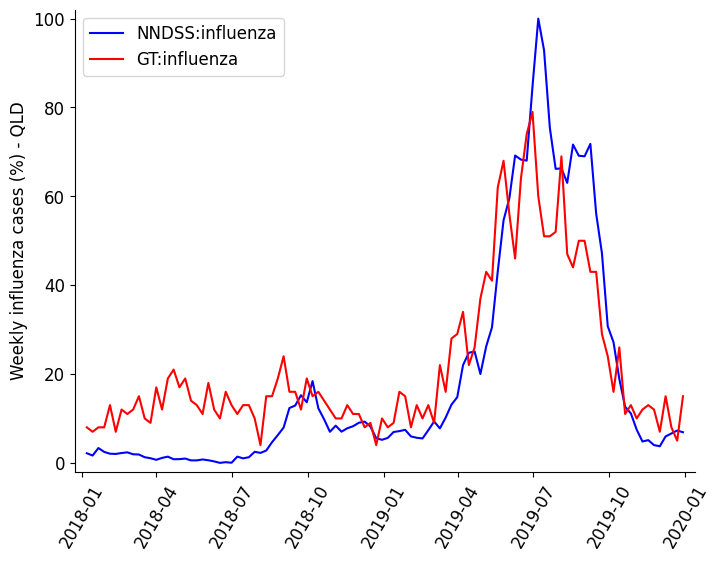

In [ ]:

# #plot figure
dates = pd.to_datetime(dates, format = '%Y-%m-%d')
plt.figure(figsize=(8, 6))
plt.plot(dates, y_scaled, 'b', label = 'NNDSS:influenza')
plt.plot(dates, X['influenza'], 'r', label = 'GT:influenza')
plt.legend()
# plt.grid(linestyle=':')
plt.ylabel("Weekly influenza cases (%) - QLD", fontsize=12) 
plt.xlabel(" ", fontsize=12) 
plt.xticks(rotation= 60) #'vertical'
plt.margins(0.02)

plt.show()

# del(y_train, y_test, X_train, X_test, y_pred, lasso, r2, rmse, pcc,mae, df_y_pred, lasso_cv)

nsw
------- Nowcast results ---------
Tuned  l1 ratio: 1.0
Tuned  alpha: 0.5
Tuned score: 0.9543
R squared: 0.9346
RMSE: 6.4944
MAE: 5.162
PCC: 0.9669
alpha: 0.5
l1 ratio: 1.0
max iter: 34
19 features, reduction of 9.52%
index of max y_test:  83
index of max y_pred:  85
{'PMD': -8.9038, 'PWD': 2}


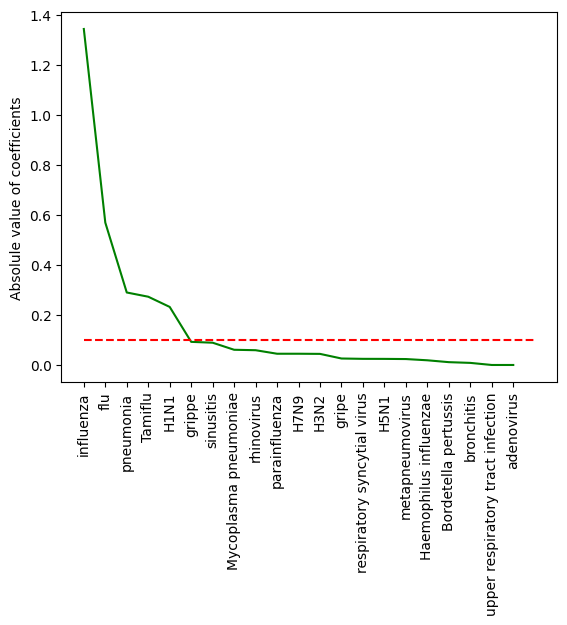

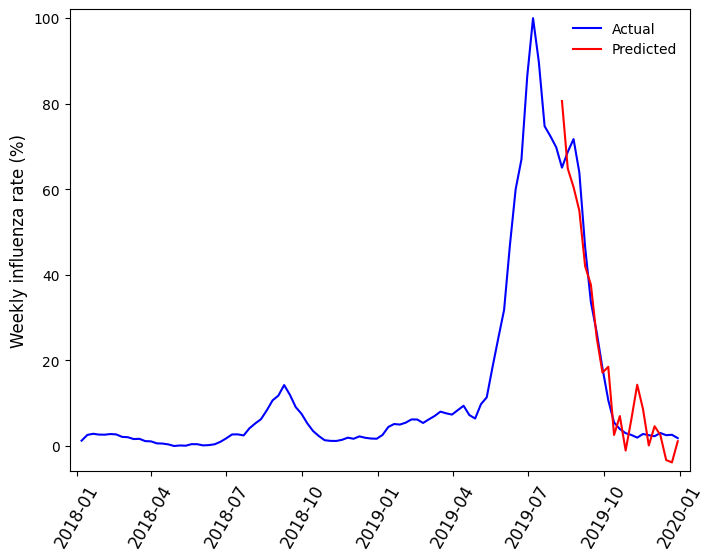

In [ ]:
#1. nowcast results 
print(state)


X_train = X_train_now
y_train =  y_train_now
X_test =  X_test_now
y_test =  y_test_now
print('------- Nowcast results ---------')

enet_cv_now, y_pred_now = enet_reg(X_train, y_train, X_test, y_test)
# svr_cv_now, y_pred_now  = svr_reg(X_train, y_train, X_test, y_test)
# rf_cv_now, y_pred_now = rf_reg(X_train, y_train, X_test, y_test)
# mlpreg_cv_now, y_pred_now = fnn_reg(X_train, y_train, X_test, y_test)



#plot prediction
y_pred_new = y_pred_now 
y_test_new = y_test
# y_train_last_1wk  = y_train_1wk.iloc[-1] #fget the last element
# y_test_new = pd.concat([pd.Series(y_train_last_1wk), y_test])
# severity(dates, y_test_new, y_pred_new, split)
severity(dates, y_test_new, y_pred_new, split)

# plot_pred(dates, y_scaled, y_pred_new , split)
p = plot_pred(dates, y_scaled, y_pred_new , split) 
# p
# p.savefig(path + '/fig_paper/FigureA1/FigA1_nsw_en_nowcast.svg', dpi=300,bbox_inches='tight') 
# p.savefig(path + '/fig_paper/FigureA1/FigA1_nsw_sv_nowcast.svg', dpi=300,bbox_inches='tight');
# p.savefig(path + '/fig_paper/FigureA1FigA7_tas_rf_nowcast.svg', dpi=300,bbox_inches='tight');
# p.savefig(path + '/fig_paper/FigureA1/FigA7_tas_fnn_nowcast.svg', dpi=300,bbox_inches='tight');

vic
------- One Week ahead results ---------
Tuned  estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('mlpreg',
                 MLPRegressor(alpha=1.0, early_stopping=True,
                              hidden_layer_sizes=(22, 50, 25), max_iter=1000,
                              random_state=1))])
Tuned  parameters: {'mlpreg__alpha': 1.0, 'mlpreg__learning_rate': 'constant'}
Tuned  R squared: -9.5406
R squared: 0.5934
RMSE: 16.5109
MAE: 10.0339
PCC: 0.8891
(21,)
index of max y_test:  83
index of max y_pred:  87
{'PMD': 5.5427, 'PWD': 4}


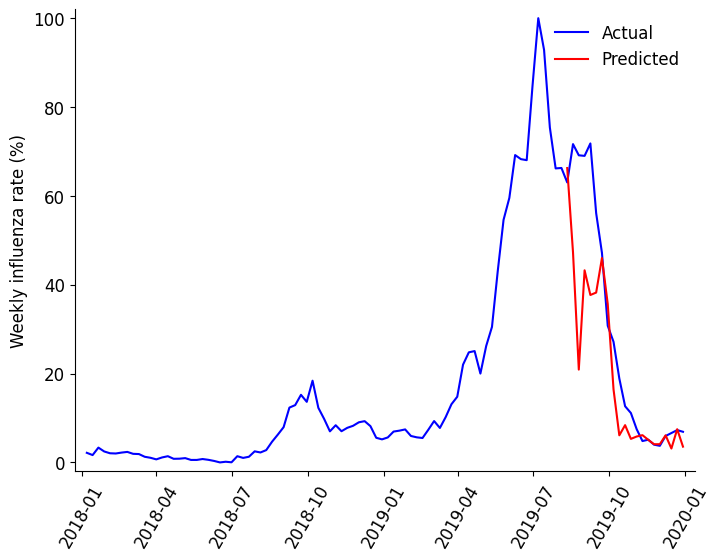

In [ ]:
#2. One  week ahead forecast results
print(state)
X_train = X_train_1wk
y_train =  y_train_1wk
X_test =  X_test_1wk
y_test =  y_test_1wk
print('------- One Week ahead results ---------')
# enet_cv_1wk, y_pred_1wk = enet_reg(X_train, y_train, X_test, y_test)
# svr_cv_1wk, y_pred_1wk = svr_reg(X_train, y_train, X_test, y_test)
# rf_cv_1wk, y_pred_1wk = rf_reg(X_train, y_train, X_test, y_test)
mlpreg_cv_1wk, y_pred_1wk = fnn_reg(X_train, y_train, X_test, y_test)

# #plot prediction
# y_pred_Xtrain_1wk  = enet_cv_1wk.predict(X_train) #compute prediction on training set
# y_pred_Xtrain_1wk = svr_cv_1wk.predict(X_train) #compute prediction on training set
# y_pred_Xtrain_1wk = rf_cv_1wk.predict(X_train) #compute prediction on training set
y_pred_Xtrain_1wk = mlpreg_cv_1wk.predict(X_train) #compute prediction on training set
y_pred_Xtrain_last_1wk  = y_pred_Xtrain_1wk [-1] #fget the last element

y_pred_new =  np.insert(y_pred_1wk,[0],y_pred_Xtrain_last_1wk) #insert at the beginig of y_pred
print(y_pred_new.shape) #21
y_train_last_1wk  = y_train_1wk.iloc[-1] #fget the last element
y_test_new = pd.concat([pd.Series(y_train_last_1wk), y_test])
severity(dates, y_test_new, y_pred_new, split)
p = plot_pred(dates, y_scaled, y_pred_new, split)
# p.savefig(path + '/fig_paper/FigureA1/FigA1_nsw_en_1wk.svg', dpi=300,bbox_inches='tight') 
# p.savefig(path + '/fig_paper/FigureA1/FigA1_nsw_sv_1wk.svg', dpi=300,bbox_inches='tight');
# p.savefig(path + '/fig_paper/FigureA1/FigA7_tas_rf_1wk.svg', dpi=300,bbox_inches='tight');
# p.savefig(path + '/fig_paper/FigureA1/FigA7_tas_fnn_1wk.svg', dpi=300,bbox_inches='tight');

vic
------- Two Weeks ahead results ---------
Tuned  estimator: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('mlpreg',
                 MLPRegressor(alpha=1.1, early_stopping=True,
                              hidden_layer_sizes=(22, 50, 25), max_iter=1000,
                              random_state=1))])
Tuned  parameters: {'mlpreg__alpha': 1.1, 'mlpreg__learning_rate': 'constant'}
Tuned  R squared: -8.6064
R squared: 0.6723
RMSE: 13.9574
MAE: 8.305
PCC: 0.8563
index of max y_test:  84
index of max y_pred:  87
{'PMD': -3.2749, 'PWD': 3}


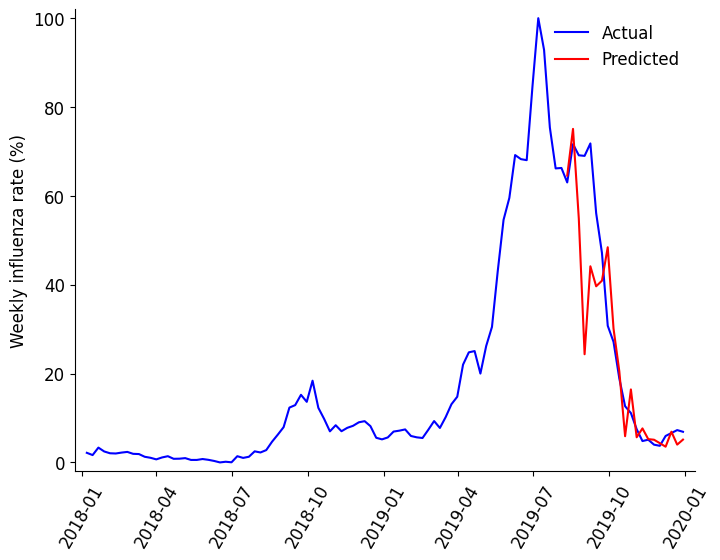

In [ ]:
#3. Two  weeks ahead forecast results 
print(state)
X_train = X_train_2wk
y_train =  y_train_2wk
X_test =  X_test_2wk
y_test =  y_test_2wk
print('------- Two Weeks ahead results ---------')

# enet_cv_2wk, y_pred_2wk = enet_reg(X_train, y_train, X_test, y_test)
# svr_cv_2wk, y_pred_2wk = svr_reg(X_train, y_train, X_test, y_test)
# rf_cv_2wk, y_pred_2wk = rf_reg(X_train, y_train, X_test, y_test)
mlpreg_cv_2wk, y_pred_2wk = fnn_reg(X_train, y_train, X_test, y_test)
# 

# #plot prediction
# y_pred_Xtrain_2wk = enet_cv_2wk.predict(X_train) #get predictions from training set
# y_pred_Xtrain_2wk = svr_cv_2wk.predict(X_train) #get predictions from training set
# y_pred_Xtrain_2wk = rf_cv_2wk.predict(X_train) #compute prediction on training set
y_pred_Xtrain_2wk = mlpreg_cv_2wk.predict(X_train) #get predictions from training set
y_pred_Xtrain_last_2wk = y_pred_Xtrain_2wk[[-2,-1]]  #get last two preditions

y_pred_new =  np.concatenate([y_pred_Xtrain_last_2wk, y_pred_2wk]) #insert at the bening of y_pred
y_train_last_2wk  = y_train_2wk.iloc[-2:] #fget the last element
y_test_new = pd.concat([pd.Series(y_train_last_2wk), y_test])
severity(dates, y_test_new, y_pred_new, split)
p = plot_pred(dates, y_scaled, y_pred_new, split)

# p.savefig(path + '/fig_paper/FigureA1/FigA1_nsw_en_2wk.svg', dpi=300,bbox_inches='tight') 
# p.savefig(path + '/fig_paper/FigureA1/FigA1_nsw_sv_2wk.svg', dpi=300,bbox_inches='tight');
# p.savefig(path + '/fig_paper/FigureA1/FigA7_tas_rf_2wk.svg', dpi=300,bbox_inches='tight');
# p.savefig(path + '/fig_paper/FigureA1/FigA7_tas_fnn_nowcast.svg', dpi=300,bbox_inches='tight');